<a href="https://colab.research.google.com/github/zzickso/CNN/blob/main/CIFAR_10_dataset(VGG_19)_NJM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

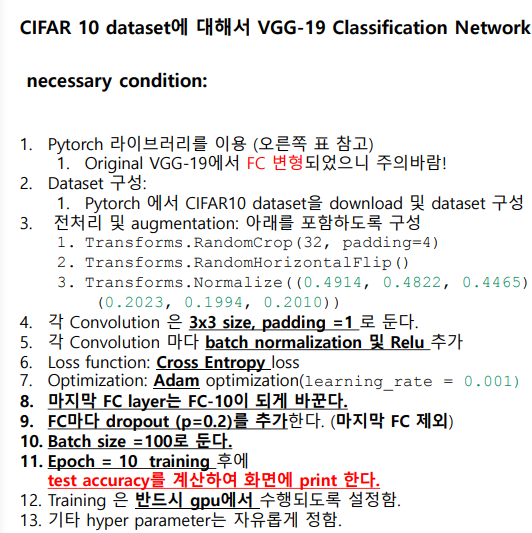

# 데이터 불러오기

In [37]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# 데이터 확인(필수 아님)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


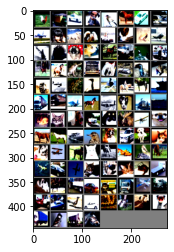

 bird truck   car   dog  bird horse   car plane plane   dog horse   dog  ship   cat  frog plane plane  bird   dog   dog horse truck  bird truck  deer horse  frog truck   cat truck  bird   cat truck plane  frog  bird   cat horse horse  ship truck truck plane horse plane   dog  ship  ship   dog   cat   dog truck   cat  deer plane   dog horse horse  ship  bird   dog   car   dog   cat   dog plane   dog   cat horse plane  bird  deer plane   car plane   cat  bird   cat  frog truck   cat  deer truck   car   cat truck plane truck truck   car  bird   car   cat   cat   cat  bird truck  bird truck horse


In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Hyperparameter

In [39]:
# Hyper parameters
num_epochs = 10
num_classes = 10
batch_size = 100
learning_rate = 0.001

# 모델 구현1
### 1) Basic Blocks

- 모델에 반복되는 부분이 많기 때문에 이를 함수로 만들어 단순화 합니다.
- 맨 위에 이미지를 보면 컨볼루션 연산이 2번 연속하는 경우와 3번 연속하는 경우가 있는데 이를 각각 만들어줍니다.
- 아래의 코드는 최적의 방법이라기 보다는 그림의 구조를 모방한 코드입니다. 

In [40]:
# 컨볼루션 연산이 2번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

# 컨볼루션 연산이 3번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

# 컨볼루션 연산이 4번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_4_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

# 모델 구현2.(VGG_19)

In [41]:
import torch.nn as nn
import torch.nn.init as init

class VGG_19(nn.Module): # VGG_19 => MNIST는 28x28 데이터 => 모든 depth 내려가면 512x0x0이 되므로 가장 마지막 블럭은 스킵
    def __init__(self, base_dim, num_classes=10):
        super(VGG_19, self).__init__()
        self.feature = nn.Sequential(
            # inp = (3,32,32)
            conv_2_block(3,base_dim), 
            # 64가 무엇? => base_dim을 64 => convolution 필터의 개수 => 채널.
            # (64,16,16)
            conv_2_block(base_dim,2*base_dim),
            # (128,8,8)  
            conv_4_block(2*base_dim,4*base_dim),
            # (256,4,4)
            conv_4_block(4*base_dim,8*base_dim),
            # (512,2,2)
            conv_4_block(8*base_dim,8*base_dim),
            # (512,1,1)            
        )
        #선별하는 과정
        self.fc_layer = nn.Sequential( 
            # inp = (512*1*1) -> 1차원
            nn.Linear(8*base_dim * 1 * 1, 1000),
            nn.ReLU(True),                                                      # True 는 inplace 연산을 하겠다는 의미를 가집니다. inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는것을 의미합니다.
            nn.Dropout(0.2),
            nn.Linear(1000, 500),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(500, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)                                               # x.size(0)를 batch size로 바꿔도 같은 값입니다.
        x = self.fc_layer(x)
        return x

# Optimizer & Loss

In [42]:
# gpu가 사용 가능한 경우에는 device를 0번 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")
print(device)

# 앞서 정의한대로 VGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = VGG_19(base_dim=64) # 참고로 강의 자료 그림은 base_dim = 64
model = model.to(device) # gpu를 사용하게 하는 것.

# 손실함수 및 최적화함수를 설정합니다. => 필요하면 긁어 쓰면 됩니다.
loss_func = nn.CrossEntropyLoss() #를 사용하겠다
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam 최적화 함수를 사용

# 모델 자녀 노드의 이름과 모듈을 출력합니다.
for i in model.named_children():
    print(i)

cuda:0
('feature', Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Con

# 학습

In [43]:
# Train the model
total_step = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)      
        loss = loss_func(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/500], Loss: 2.0611
Epoch [1/10], Step [200/500], Loss: 1.8736
Epoch [1/10], Step [300/500], Loss: 1.7964
Epoch [1/10], Step [400/500], Loss: 1.7549
Epoch [1/10], Step [500/500], Loss: 1.7565
Epoch [2/10], Step [100/500], Loss: 1.6390
Epoch [2/10], Step [200/500], Loss: 1.6462
Epoch [2/10], Step [300/500], Loss: 1.8001
Epoch [2/10], Step [400/500], Loss: 1.6500
Epoch [2/10], Step [500/500], Loss: 1.6341
Epoch [3/10], Step [100/500], Loss: 1.4660
Epoch [3/10], Step [200/500], Loss: 1.5228
Epoch [3/10], Step [300/500], Loss: 1.5687
Epoch [3/10], Step [400/500], Loss: 1.2668
Epoch [3/10], Step [500/500], Loss: 1.3556
Epoch [4/10], Step [100/500], Loss: 1.2353
Epoch [4/10], Step [200/500], Loss: 1.2714
Epoch [4/10], Step [300/500], Loss: 1.0637
Epoch [4/10], Step [400/500], Loss: 1.1102
Epoch [4/10], Step [500/500], Loss: 1.1067
Epoch [5/10], Step [100/500], Loss: 1.3051
Epoch [5/10], Step [200/500], Loss: 1.2583
Epoch [5/10], Step [300/500], Loss: 0.9967
Epoch [5/10

In [ ]:
# 학습 방법2
# for i in range(num_epochs):
#     for j,[image,label] in enumerate(trainloader):
#         x = image.to(device)
#         y_= label.to(device)

#     # 역전파 단계 전에, optimizer 객체를 사용하여 (모델의 학습 가능한 가중치인) 갱신할
#     # 변수들에 대한 모든 변화도(gradient)를 0으로 만듭니다. 이렇게 하는 이유는 기본적으로 
#     # .backward()를 호출할 때마다 변화도가 버퍼(buffer)에 (덮어쓰지 않고) 누적되기
#     # 때문입니다. 더 자세한 내용은 torch.autograd.backward에 대한 문서를 참조하세요.
#         optimizer.zero_grad() # 학습 진행하면서 미분값을 계산.
#         output = model.forward(x) # 학습 -> forward propagation
#         loss = loss_func(output,y_)
#         loss.backward() # 역전파 -> back propagation
#         optimizer.step()

#     if i % 10 ==0:
#         print(loss) # 손실값을 출력.

# 정확도 확인

In [44]:
# Test the model again using the saved weight file
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad(): # gradient 계산을 안한다. => 예측이기 때문에 미분값을 계산할 필요가 없기 때문에 메모리와 속도를 아낄 수 있다.
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 78.84 %
